In [101]:
%%capture 
%load_ext autoreload
%autoreload 2
%reset -f

In [102]:
from functions import *

## **Import the EEG Data and set the Global Variables**
<img src="readme_images/ElectrodePlacement.jpg" width="400">

In [103]:
chan_name = ['O1','PO7', 'PO3', 'POz', 'Oz', 'O2', 'PO4', 'PO8']
fs, lf, hf = 250, 1, 30 #Hz

import os
def process_folder(path_to_folder, chan_name):
    eeg_data = []    
    for filename in os.listdir(path_to_folder):
        if '_ExG.csv' in filename:
            full_path = os.path.join(path_to_folder, filename)
            eeg_data.append(EEG_Data(full_path,title = filename[:filename.rindex('_')], chan_name=chan_name))
    
    return eeg_data


eeg_data = process_folder('data/Fatjon-23March', chan_name)
eeg_data[0]= EEG_Data('data/BinocularVR-22March/experiment1_ExG.csv', title='e1_Side', chan_name=chan_name, stimulus_frequency=[7.5,10])
# eeg_data.append(EEG_Data('data/BinocularVR-22March/experiment1_ExG.csv', title='e1_Overlapped', chan_name=chan_name, stimulus_frequency=[7.5,10]))

# eeg_data.append(EEG_Data('data/BinocularVR-22March/experiment2_ExG.csv', title='e2_Colour', chan_name=chan_name, stimulus_frequency=[7.5,10]))
# eeg_data.append(EEG_Data('data/BinocularVR-22March/experiment2_ExG.csv', title='e2_BW', chan_name=chan_name, stimulus_frequency=[7.5,10]))

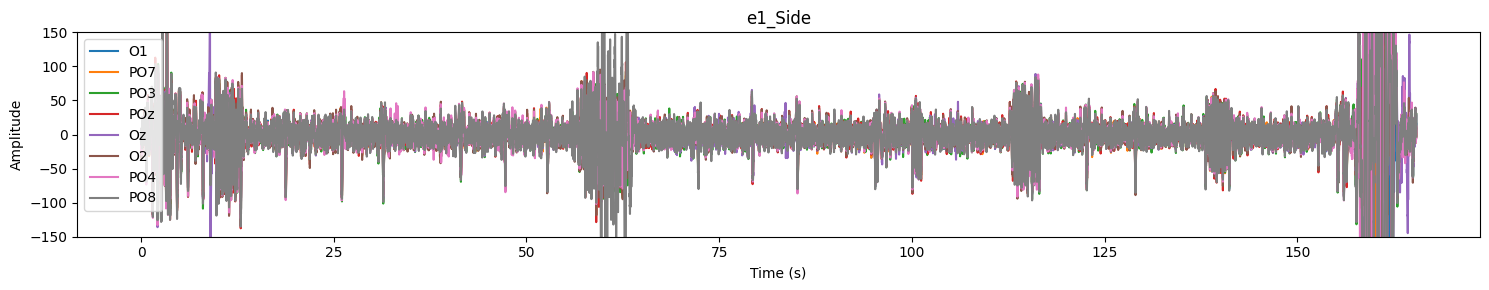

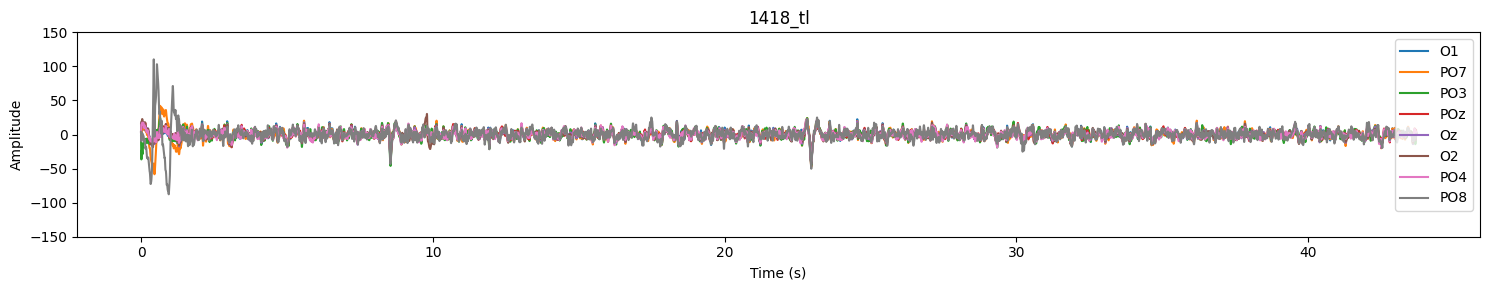

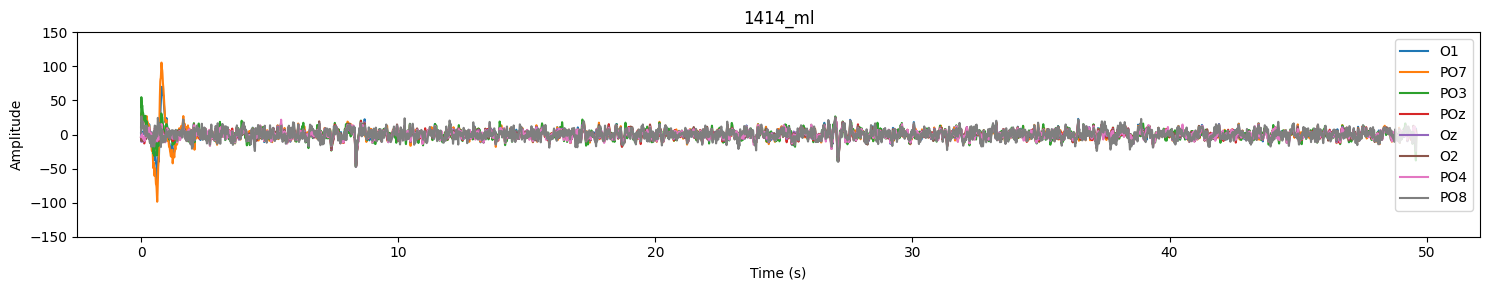

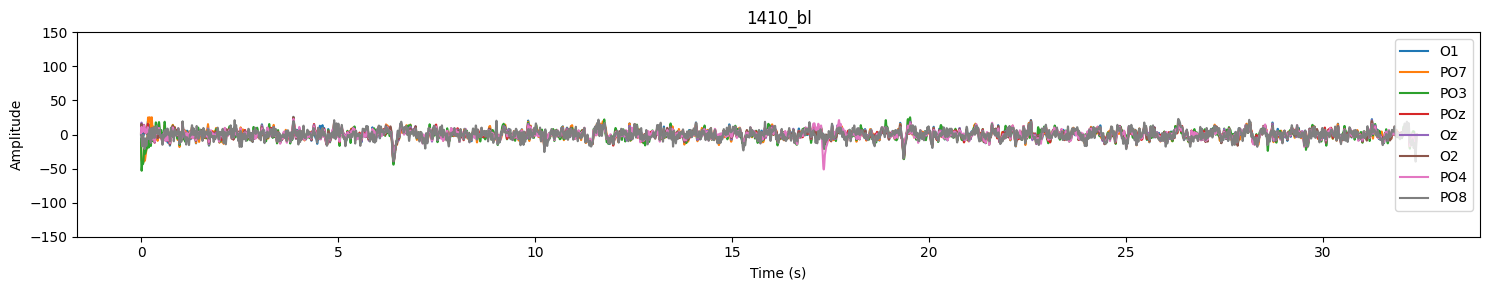

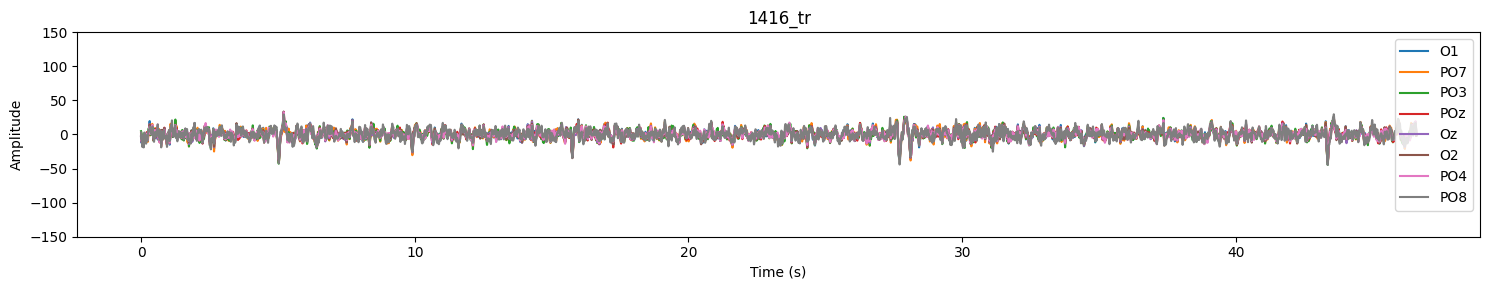

In [104]:
for eeg in eeg_data:
    amplitude_plot(eeg.filtered_signal, chan_name, title=(eeg.title))

In [105]:
# # TODO: automate this. look into the labstreaming layers and the markers
eeg_data[0].cut_signal(15, 55, cut_to=True)
# eeg_data[1].cut_signal(65, 115, cut_to=True)
# eeg_data[2].cut_signal(22, 70, cut_to=True)
# eeg_data[3].cut_signal(84, 125, cut_to=True)
# cut first 5 seconds and last 5 seconds
for eeg in eeg_data:
    eeg.cut_signal(5, 5, cut_to=False)

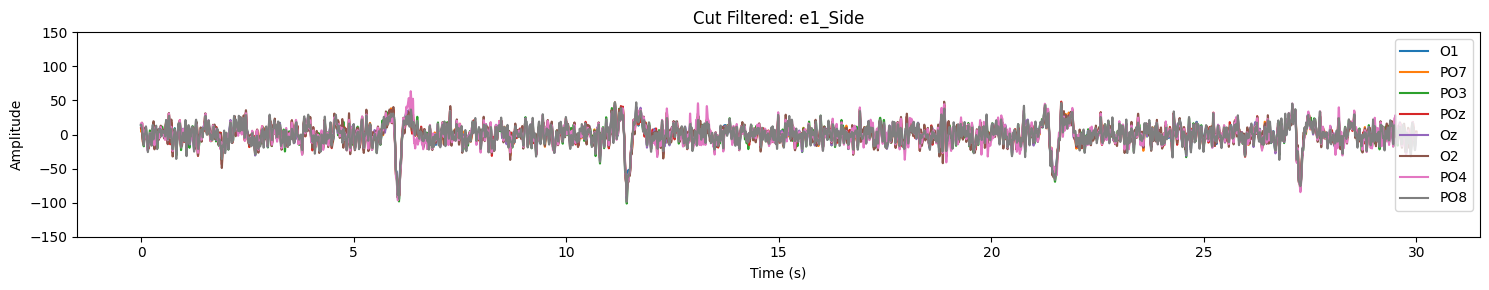

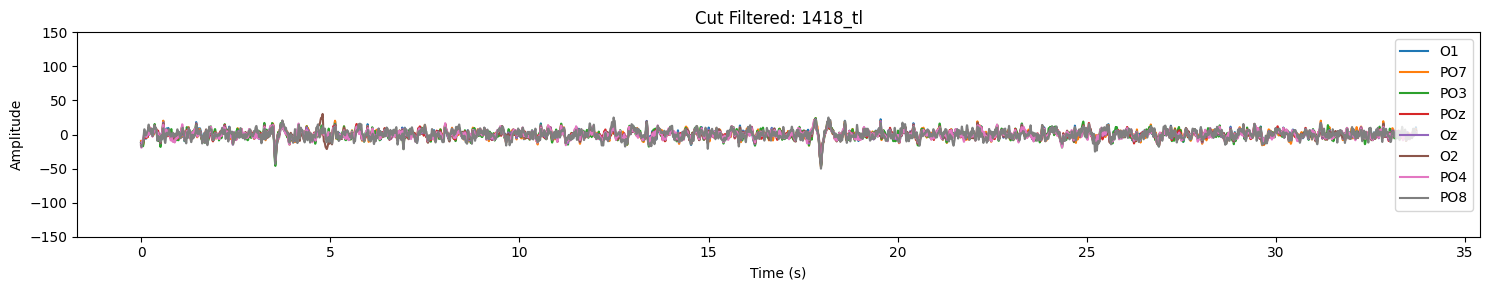

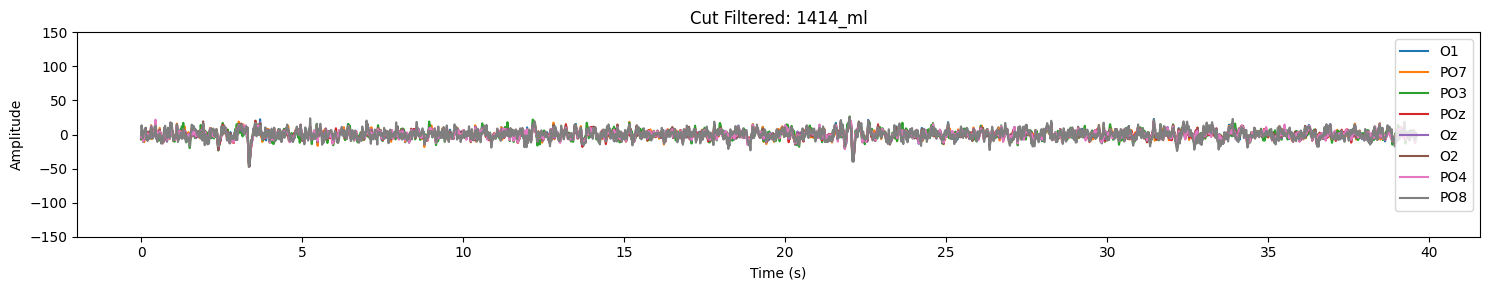

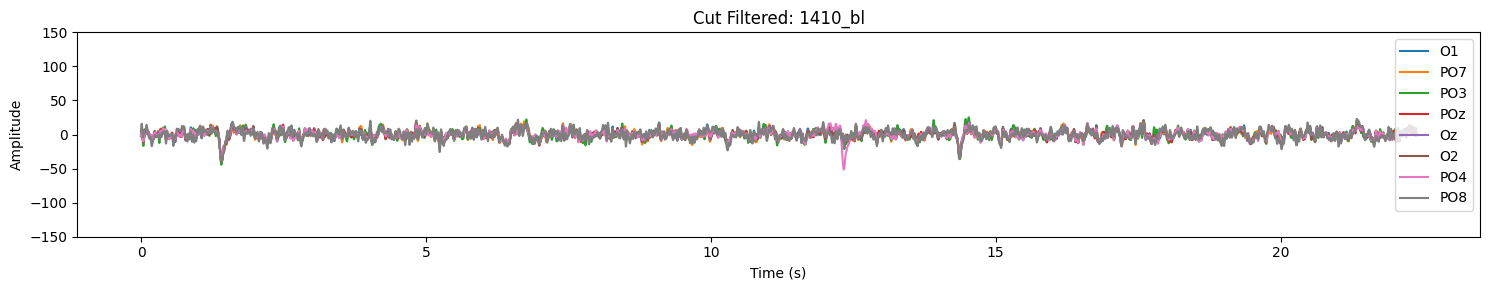

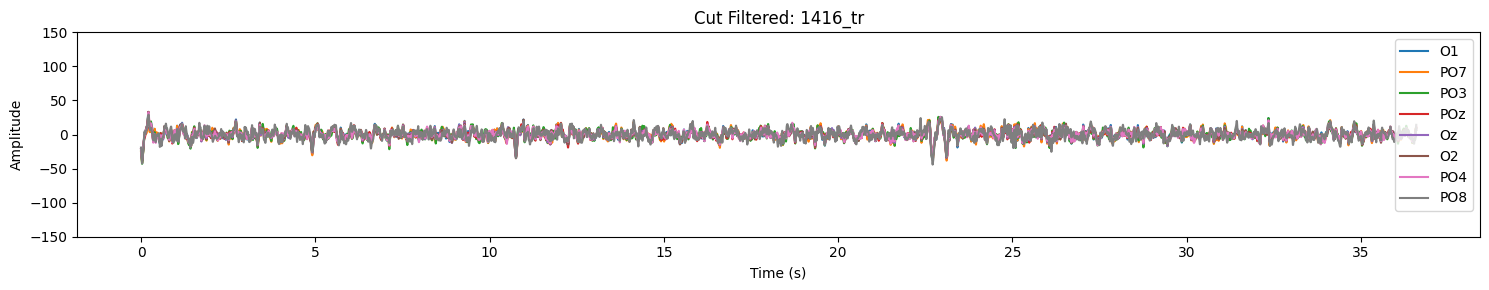

In [106]:
for eeg in eeg_data:
    amplitude_plot(eeg.filtered_signal, chan_name, title=("Cut Filtered: "+eeg.title))

In [111]:
psd_plot_interactive(eeg_data, chan_name, nperseg_max=20, nfft_max=20, fig_x=15,fig_y=3, y_lim=150)

interactive(children=(IntSlider(value=20, description='nperseg*fs:', max=20, min=1), IntSlider(value=20, descr…

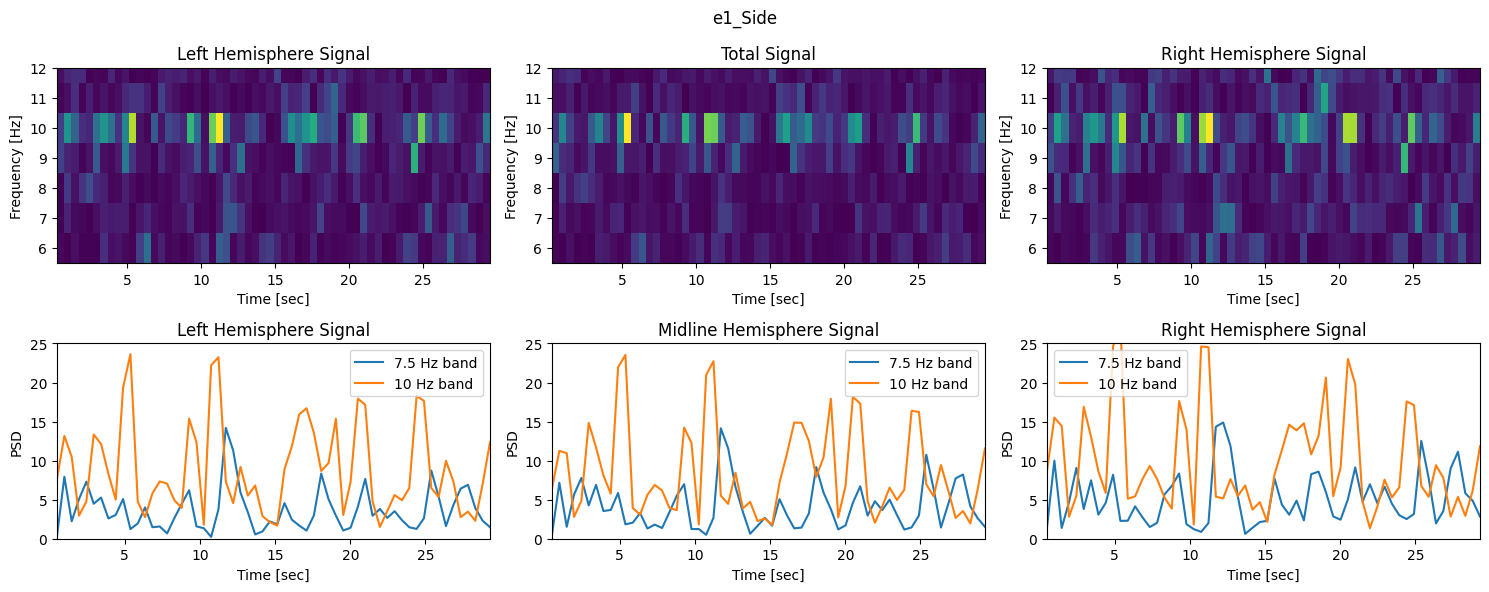

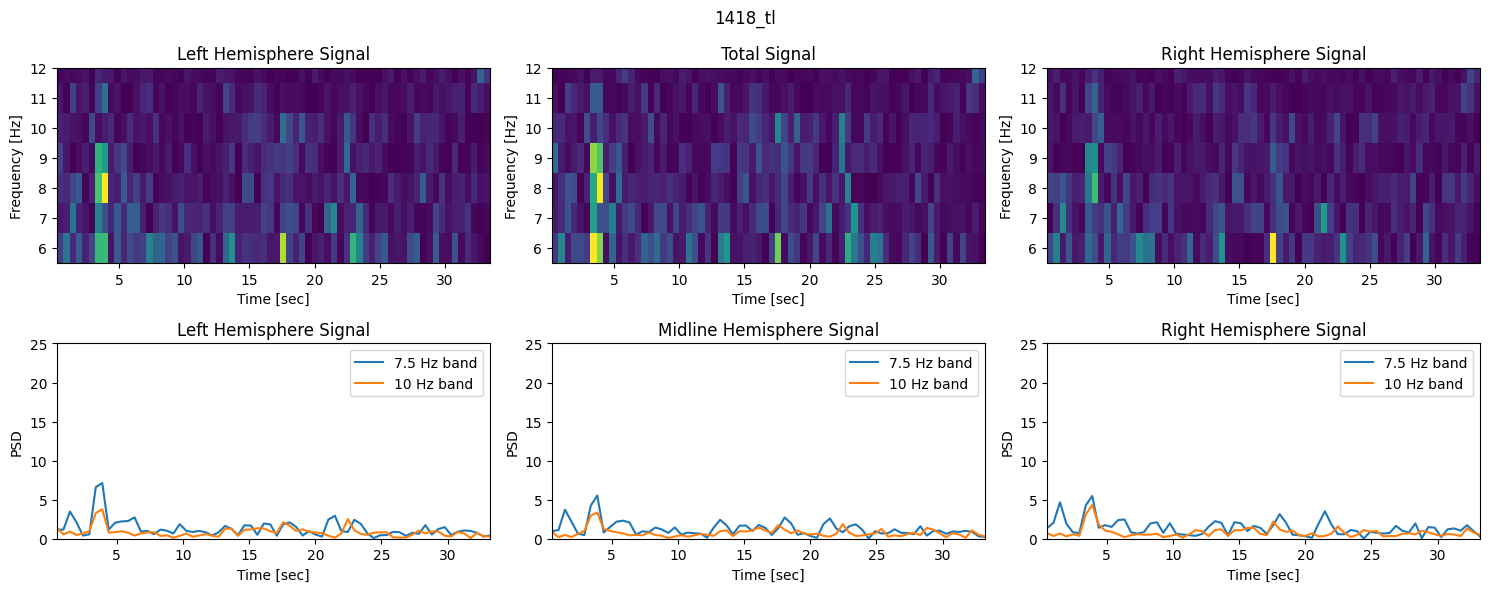

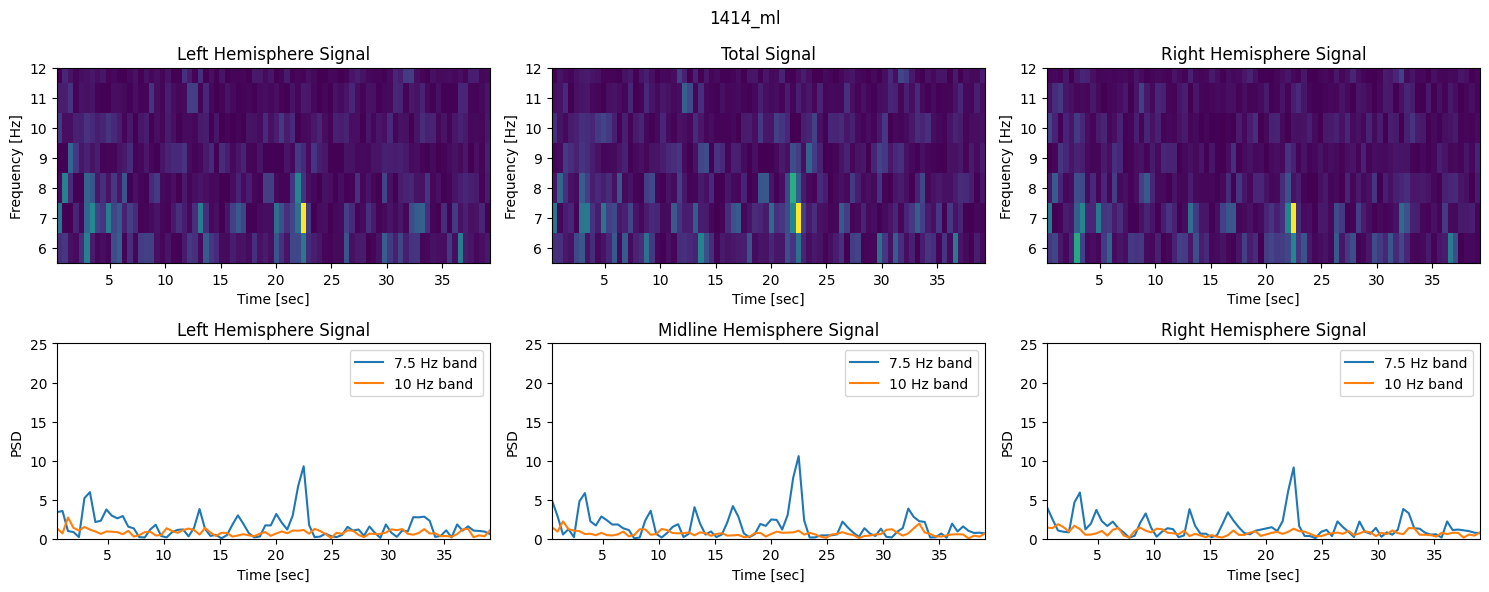

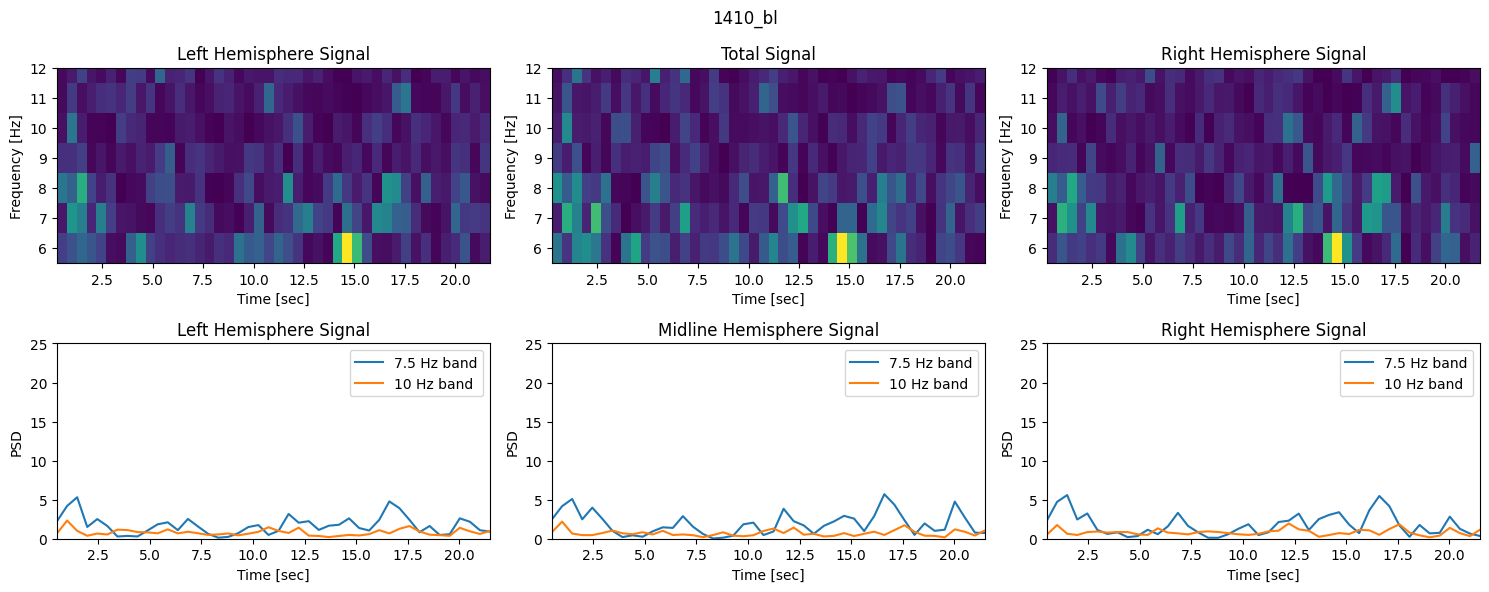

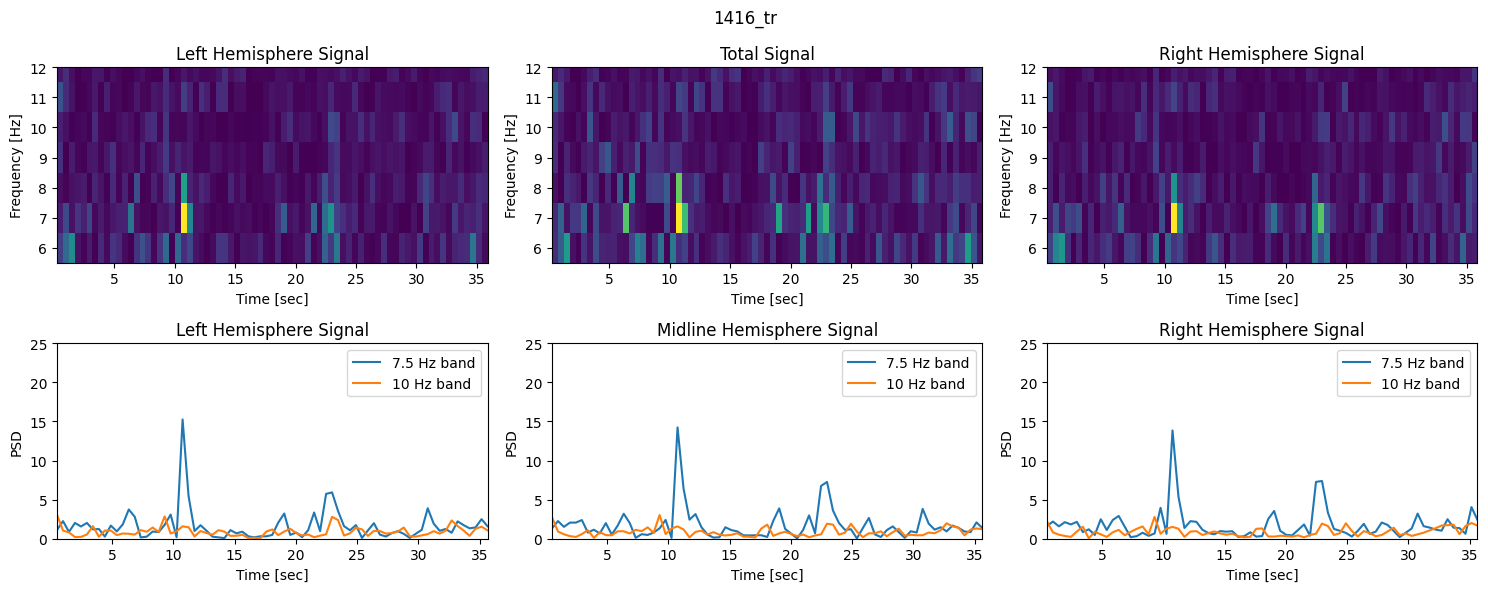

In [108]:
def chan_hemisphere(chan_name):
    # left hemisphere -> odd numbers (1,3,5,7) 
    left_hemisphere = [chan for chan in chan_name if chan[-1].isdigit() and int(chan[-1]) % 2 != 0]
    # right hemisphere -> even numbers (2,4,6,8)
    right_hemisphere = [chan for chan in chan_name if chan[-1].isdigit() and int(chan[-1]) % 2 == 0]
    # midline -> z
    midline_hemisphere = [chan for chan in chan_name if chan[-1] == 'z']
    return left_hemisphere, midline_hemisphere, right_hemisphere

def hemisphere_signal_avg(eeg, chan_name):
    left_hemisphere, midline_hemisphere, right_hemisphere = chan_hemisphere(chan_name)

    # seperate the signal into left and right hemisphere and take the average per channel
    left_hemisphere_signal = np.mean(eeg.filtered_signal[[chan_name.index(chan) for chan in left_hemisphere],:], axis=0)
    right_hemisphere_signal = np.mean(eeg.filtered_signal[[chan_name.index(chan) for chan in right_hemisphere],:], axis=0)
    midline_hemisphere_signal = np.mean(eeg.filtered_signal[[chan_name.index(chan) for chan in midline_hemisphere],:], axis=0)
    
    return left_hemisphere_signal, midline_hemisphere_signal, right_hemisphere_signal

def plot_spectrogram_and_bands(eeg,title=None, band_freqs=None, f_min=5, f_max=15, fs=250):
    f_min = min(band_freqs) - 2
    f_max = max(band_freqs) + 2
    # total_signal = np.mean(eeg.filtered_signal, axis=0)
    total_signal = eeg.filtered_signal[2]
    left_hemisphere_signal, midline_hemisphere_signal, right_hemisphere_signal = hemisphere_signal_avg(eeg, chan_name)

    def masked_spectogram(singal, nperseg=1,nfft=1):
        frequencies, times, spectrogram = signal.spectrogram(singal, fs=fs, nperseg=fs*nperseg, noverlap=128, scaling='spectrum', mode='psd', nfft=fs*nfft)
        mask = (frequencies >= f_min) & (frequencies <= f_max)
        spectrogram_masked = spectrogram[mask, :]
        frequencies_masked = frequencies[mask]
        return frequencies_masked, times, spectrogram_masked
    
    # Plot the spectrogram using matplotlib
    fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(15, 6))
    def plot_sepctro(ax, signal, title):
        frequencies_masked, times, spectrogram_masked = masked_spectogram(signal)
        ax.pcolormesh(times, frequencies_masked, spectrogram_masked)
        ax.set_ylim(f_min, f_max)
        ax.set_ylabel('Frequency [Hz]')
        ax.set_xlabel('Time [sec]')
        ax.set_title(title)
    
    plot_sepctro(axs[0,0], left_hemisphere_signal, 'Left Hemisphere Signal')
    plot_sepctro(axs[0,1], total_signal, 'Total Signal')
    plot_sepctro(axs[0,2], right_hemisphere_signal, 'Right Hemisphere Signal')

    def plot_bands(ax, signal, title):
        frequencies_masked, times, spectrogram_masked = masked_spectogram(signal)
        # Plot the PSDs in the frequency bands of interest through time
        for i, band_freq in enumerate(band_freqs):
            band_mask = (frequencies_masked >= band_freq-1) & (frequencies_masked <= band_freq+1)
            psd = np.mean(spectrogram_masked[band_mask, :], axis=0)
            ax.plot(times, psd, label=f'{band_freqs[i]} Hz band')
        ax.set_xlim(times[0], times[-1])
        ax.set_ylim(0, 25)
        ax.set_xlabel('Time [sec]')
        ax.set_ylabel('PSD')
        ax.legend()
        ax.set_title(title)

    # plot_bands(axs[1], total_signal, 'Total Signal')   
    plot_bands(axs[1,0], left_hemisphere_signal, 'Left Hemisphere Signal')
    plot_bands(axs[1,1], midline_hemisphere_signal, 'Midline Hemisphere Signal')
    plot_bands(axs[1,2], right_hemisphere_signal, 'Right Hemisphere Signal')
    
    if title:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()
    
for eeg in eeg_data: 
    plot_spectrogram_and_bands(eeg, title = eeg.title, band_freqs=[7.5,10])

In [109]:
# %%capture 
# # get the min stimulus frequency from the eeg data
# min_freq = 5
# for eeg in eeg_data:
#     if eeg.stimulus_frequency:
#         if eeg.stimulus_frequency <= min_freq:
#             min_freq = eeg.stimulus_frequency - 2

# # get the max stimulus frequency from the eeg data
# max_freq = 15
# for eeg in eeg_data:
#     if eeg.stimulus_frequency:
#         if eeg.stimulus_frequency >= max_freq:
#             max_freq = eeg.stimulus_frequency+2

# freqs = np.arange(min_freq, max_freq, .3)
# n_cycles = freqs
# t_min, t_max = 1, 6


# # Get the class names
# class_names = [eeg.title for eeg in eeg_data]

# times = np.linspace(t_min, t_max, eeg_data[0].epochs.shape[2])

# # compute power for each epoch
# power = []
# for eeg in eeg_data:
#     power.append(mne.time_frequency.tfr_array_morlet(eeg.epochs, sfreq=fs, freqs=freqs, n_cycles=n_cycles, output='avg_power'))

# power_stack = np.stack(power)

# for pow in power:
#     mne.baseline.rescale(pow, times, (None, times[0]), mode='mean', copy=False)
    
# power = power_stack

In [110]:
# x, y = mne.viz.centers_to_edges(times, freqs)

# fig, ax = plt.subplots(n_chan, len(class_names), figsize=(15, 15))
# for j in range(len(class_names)):
#     for i in range(n_chan):
#         mesh = ax[i, j].pcolormesh(x, y, power[j, i], cmap='RdBu_r', vmin=-3500, vmax=1500)
#         ax[i, j].set_title('TFR - ' + chan_name[i] + ' - ' + class_names[j])
#         ax[i, j].set(ylim=freqs[[0, -1]], xlabel='T(s)', ylabel='F(Hz)')
#         if eeg_data[j].stimulus_frequency:
#             ax[i, j].axhline(y=eeg_data[j].stimulus_frequency, linestyle='--', color='white')
# plt.tight_layout()
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(mesh, cax=cbar_ax)
# plt.show()